<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%203/MINE4210_ADL2024_Lab3_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

**Tutores**.
* Nicolás Tibatá Casteñeda.
* Fabián Camilo Castellanos P.

#Tabla de contenido

[Contexto y objetivos.](#scrollTo=Gm-CkXorSv_r)<br>
[Entendimiento del negocio.](#scrollTo=VmAdljrOTGGC)<br>
[0. Instalación de librerías.](#scrollTo=ymdEVvQHTHjE)<br>
[1. Importar librerías](#scrollTo=NzcrGRCiTsCH)<br>
[2. Introducción a los datos.](#scrollTo=1Y0vo6BLTQEM)<br>
[3. Modelamiento.](#scrollTo=jhNndBZjTWc5)<br>
[4. Preguntas.](#scrollTo=wdbaxm6ATX1V)<br>

# **Laboratorio 3 - Sesión 2**
## **Redes Recurrentes**

## **Objetivos**
* Analizar la construcción de una Red Neuronal Recurrente.
* Entrenar una red recurrente LSTM para resolver un problema de análisis de sentimientos.

# Entendimiento del negocio.

La universidad de los Andes ha evidenciado que nos es ajena a la situación presentada por inteligencia artificial. Chat GPT ha tomado fuerza en los últimos años y su uso ético viene generando preocupación, no sólo para la Universidad, sino para la comunidad académica en general.

Por esta razón, mediante la red Social X, fue generado el debate de las implicaciones de Chat GPT no sólo en el ámbito académico, sino en la vida diaria.

Como un primer ejercicio de acercamiento para la percepción de la comunidad en redes sociales, ha sido etiquetada la información acerca de de las opiniones, catalogando como un análisis de polaridad o de sentimientos, clasificando la información como positivo, negativo o neutro.

De esta forma la Universidad tomará esta información como punto de partida para evaluación de acciones a futuro.

Toda la información ha sido consolidada en el siguiente [enlace](https://www.kaggle.com/datasets/evilspirit05/tweet-gpt).

# 0. Instalación de librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.4 MB/s eta 0:00:00


In [3]:
!pip install num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 4.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=f5f691416b5bf28ddb45f99edf533df755cbbc6220f13521270cc21ba6709222
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


Glove, lo revisaremos más adelante

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-10-10 13:58:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-10 13:58:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-10 13:58:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

---
# 1. Importar librerías

In [5]:
import pandas as pd
import numpy as np

import os
import os.path as osp

import matplotlib.pyplot as plt
%matplotlib inline

import num2words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

import tensorflow as tf
import keras_tuner as kt

import contractions
import unicodedata, re

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TextVectorization, Embedding
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer

print('Tensorflow version:', tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tensorflow version: 2.17.0


---
# 2. Introducción a los datos.

##2.1. Parámetros generales y carga de la información.

In [6]:
MY_SEED = 19 #Semilla para reproducibilidad

#Campos del archivo de texto para involucrar en el proceso
SENTIMENT_FIELD = "sentiment"
TEXT_FIELD = "Tweet"

## 2.2. Configuración del entorno de kaggle.

Cargamos el archivo de credenciales de Kaggle:

In [7]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 69 Oct 10 13:58 kaggle.json


Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [8]:
!kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                          94KB  2024-09-02 10:53:57          27941        490  1.0              
abdulszz/spotify-most-streamed-songs                          Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14          10578        139  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12           3336         66  1.0              
thomasfranois/worlds-best-restaurants                         World's 

Una vez hemos asegurado la conectividad, procedemos a realizar el proceso de descarga de la información del negocio.

In [9]:
!kaggle datasets download evilspirit05/tweet-gpt

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/tweet-gpt
License(s): MIT
 52% 5.00M/9.54M [00:00<00:00, 34.0MB/s]
100% 9.54M/9.54M [00:00<00:00, 56.3MB/s]


## 2.3. Preparación de datos.

El objetivo del preprocesamiento es limpiar y estandarizar el texto para que sea más adecuado para su uso.

Para la información que vamos a descomprimir, es necesario crear un un directorio para que el contenido del archivo zip, se encuentre allí. Para este propósito, vamos a crear unas variables de manejo de archivos:

In [10]:
ROOT_DIR = '/content'
DATASET_NAME = 'tweet-gpt'
DATASET_FILENAME = 'tweet_gpt'

Vamos ahora a generar una previsualización del comando de descompresión del archivo zip:

In [11]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}")

!unzip tweet-gpt.zip -d /content


Ahora si vamos a consolidar el bloque de comandos con todos los pasos para la descompresión del archivo zip:

In [12]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  tweet-gpt.zip
  inflating: /content/tweet-gpt/tweet_gpt.csv  


Generamos una variable con la ruta de la información, de esta forma la podemos usar en los casos que sea requerido el acceso a los datos:

In [13]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}"
print(DATA_DIR)
DATA_PATH = f"{DATA_DIR}/{DATASET_FILENAME}.csv"
print(DATA_PATH)

/content/tweet-gpt
/content/tweet-gpt/tweet_gpt.csv


Cargamos la información a un dataframe de pandas:

In [14]:
data = pd.read_csv(DATA_PATH)
data.head(10)

,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,...,New_Date,Time,Hour,Day,TweetStr,hashtags,clean_tweet,sentiment_label,sentiment_score,sentiment
0,2023-04-08 03:31:08+00:00,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,https://twitter.com/tubeblogger/status/1644543...,tubeblogger,2013-06-25 01:42:59+00:00,False,312.0,293.0,0.0,0,...,2023-04-08,03:31:08,3,Saturday,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,"['ai', 'ChatGPT']",openai’s gpt4 just got supercharged!,-,0.917779,positive
1,2023-04-08 03:30:51+00:00,"""Classical art"" is struggling - not changed th...",https://twitter.com/majorradic/status/16445432...,majorradic,2011-12-12 01:29:15+00:00,False,522.0,684.0,0.0,2,...,2023-04-08,03:30:51,3,Saturday,"""Classical art"" is struggling - not changed th...","['ChatGPT', 'chatgpt3', 'AIArtwork', 'AI', 'AI...","classical art"" is struggling not changed the ...",-,0.515711,neutral
2,2023-04-08 03:30:00+00:00,Alibaba invites businesses to trial 'ChatGPT r...,https://twitter.com/gadgetsnow/status/16445430...,gadgetsnow,2010-07-29 10:32:28+00:00,True,90392.0,56.0,0.0,0,...,2023-04-08,03:30:00,3,Saturday,Alibaba invites businesses to trial 'ChatGPT r...,"['Alibaba', 'ChatGPT']",alibaba invites businesses to trial chatgpt ri...,-,0.924410,neutral
3,2023-04-08 03:28:59+00:00,Trying to stop students from using #AI and #ch...,https://twitter.com/Sherab_Taye/status/1644542...,Sherab_Taye,2010-05-10 12:40:40+00:00,False,338.0,53.0,0.0,0,...,2023-04-08,03:28:59,3,Saturday,Trying to stop students from using #AI and #ch...,"['AI', 'chatGPT']",trying to stop students from using and is like...,-,0.636237,negative
4,2023-04-08 03:28:31+00:00,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,https://twitter.com/cryptoccentral/status/1644...,cryptoccentral,2023-01-27 00:12:12+00:00,False,1.0,2.0,0.0,2,...,2023-04-08,03:28:31,3,Saturday,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,"['crypto', 'bitcoin', 'cryptocurrency', 'ai', ...",i asked chatgpts ai chatbot how can i earn cry...,-,0.916693,neutral
5,2023-04-08 03:26:16+00:00,Gugenka team has created a fun Customize new p...,https://twitter.com/kiradragonp/status/1644542...,kiradragonp,2010-07-03 19:13:52+00:00,False,895.0,635.0,0.0,1,...,2023-04-08,03:26:16,3,Saturday,Gugenka team has created a fun Customize new p...,"['ChatGPT', 'Hubs', 'MozillaHubs', 'webvr', 'x...",gugenka team has created a fun customize new p...,-,0.824792,positive
6,2023-04-08 03:23:05+00:00,https://t.co/cDAXMevBtr\nThe race to develop #...,https://twitter.com/CDOTrends/status/164454134...,CDOTrends,2018-03-10 10:19:45+00:00,False,1051.0,2439.0,0.0,1,...,2023-04-08,03:23:05,3,Saturday,https://t.co/cDAXMevBtr\nThe race to develop #...,"['AI', 'tech', 'ChatGPT', 'CDOTrends', 'Databr...",the race to develop models with instructionfol...,-,0.647254,neutral
7,2023-04-08 03:22:50+00:00,Took ~90 minutes but I convinced #ChatGPT that...,https://twitter.com/tctimmeh/status/1644541282...,tctimmeh,2012-01-07 19:51:51+00:00,False,300.0,415.0,0.0,1,...,2023-04-08,03:22:50,3,Saturday,Took ~90 minutes but I convinced #ChatGPT that...,['ChatGPT'],took ~90 minutes but i convinced that theres n...,-,0.372271,positive
8,2023-04-08 03:22:03+00:00,"Share tweets with my free chat GPT, Telegram b...",https://twitter.com/xTweetsio/status/164454108...,xTweetsio,2023-03-12 17:42:58+00:00,False,2053.0,6.0,0.0,1,...,2023-04-08,03:22:03,3,Saturday,"Share tweets with my free chat GPT, Telegram b...","['chatGPT', 'tweets', 'AI', 'free', 'Twitterbot']","share tweets with my free chat gpt, telegram b...",-,0.929390,positive
9,2023-04-08 03:22:03+00:00,🚀 Discover the power of #ChatGPT with our begi...,https://twitter.com/yuhanito/status/1644541085...,yuhanito,2022-08-07 09:26:32+00:00,False,39.0,50.0,0.0,0,...,2023-04-08,03:22:03,3,Saturday,🚀 Discover the power of #ChatGPT with our begi...,"['ChatGPT', 'AI', 'DigitalTransformation']",discover the power of with our beginnerfriendl...,-,0.921280,positiv

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37460 entries, 0 to 37459
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             37460 non-null  object 
 1   Tweet            37460 non-null  object 
 2   Url              37460 non-null  object 
 3   User             37460 non-null  object 
 4   UserCreated      37460 non-null  object 
 5   UserVerified     37460 non-null  bool   
 6   UserFollowers    37460 non-null  float64
 7   UserFriends      37460 non-null  float64
 8   Retweets         37460 non-null  float64
 9   Likes            37460 non-null  int64  
 10  Location         37460 non-null  object 
 11  Description      37460 non-null  object 
 12  New_Date         37460 non-null  object 
 13  Time             37460 non-null  object 
 14  Hour             37460 non-null  int64  
 15  Day              37460 non-null  object 
 16  TweetStr         37460 non-null  object 
 17  hashtags    

Realizamos la revisión de texto para cada uno de los sentimientos:

In [16]:
unique_sentiments = data[SENTIMENT_FIELD].unique()

for sentiment in unique_sentiments:
  row = data[data[SENTIMENT_FIELD] == sentiment].iloc[0]  # Obtener la primera fila con el valor de sentimiento específico
  print("Sentiment:", sentiment)
  print("Sentence:", row[TEXT_FIELD])

Sentiment: positive
Sentence: OpenAI’s GPT-4 Just Got Supercharged! #ai #ChatGPT  https://t.co/RgMkZlYuRn
Sentiment: neutral
Sentence: "Classical art" is struggling - not changed the fact that is disappearing.

ARTofficial:
It is important that 1/100 passes.
Thousands and thousands will be made.

#ChatGPT #chatgpt3
#AIArtwork #AI #AIPAD
#NFT #Web3 #chatgpt4 #nftarti̇st #AIart #nftart
#NFTJapan #Bing #BingAI
Sentiment: negative
Sentence: Trying to stop students from using #AI and #chatGPT is like trying to stop them from using internet in the early 90s.


Revisamos la distribución de los valores únicos de los sentimientos:

In [17]:
data[SENTIMENT_FIELD].value_counts()

,count
sentiment,
neutral,19218
positive,11705
negative,6537


Ahora vamos a limpiar y estandarizar el texto para que sea más adecuado para su uso.

In [18]:
def remove_stopwords(words):
  for word in STOPWORDS:
    token = ' ' + word + ' '
    words = re.sub(token, ' ', words)
  return words

def preproccesing(words):
    #Convertir el texto a minúsculas
    words = words.lower()
    #Convertir números a palabras
    #words = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), words)
    #remove_punctuation se omite el caracter - dado que en inglés se usa en palabras compuestas.
    words = re.sub(r"([\"(),¡!¿?:;'></]|\\s)+", "", words)
    #Remover caracteres No ASCII
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #Remover Stopwords
    words = remove_stopwords(words)
    #Hacer Stemming and lematización
    #words = stem_and_lemmatize(words)
    return words

In [19]:
data[TEXT_FIELD] = data[TEXT_FIELD].apply(contractions.fix)
data[TEXT_FIELD] = data[TEXT_FIELD].apply(preproccesing)

In [20]:
data[TEXT_FIELD]

,Tweet
0,openais gpt-4 got supercharged #ai #chatgpt h...
1,classical art struggling - changed fact disapp...
2,alibaba invites businesses trial chatgpt rival...
3,trying stop students using #ai #chatgpt like t...
4,i asked chatgpts ai chatbot earn crypto | trad...
...,...
37455,@intuitmachine @ylecun could true #chatgpt plu...
37456,it bad anymore terrible regular expressions. t...
37457,geometric comprehension on\n#chatgpt #ai https...
37458,i conversation @chatgptandai different ai syst...


Verificamos si hay datos duplicados:

In [21]:
data.duplicated().sum()

0

¿Los sentimientos están listos?. No, debemos hacer la transformación a números.

In [22]:
label_encoder = LabelEncoder()
data[SENTIMENT_FIELD] = label_encoder.fit_transform(data[SENTIMENT_FIELD])

unique_labels = label_encoder.classes_
for valor_numerico, etiqueta_original in enumerate(unique_labels):
    print(f'Valor numérico: {valor_numerico}, Etiqueta original: {etiqueta_original}')

Valor numérico: 0, Etiqueta original: negative
Valor numérico: 1, Etiqueta original: neutral
Valor numérico: 2, Etiqueta original: positive


## 2.4. Separación de los conjuntos de datos.

Hacemos la división de los conjuntos para entrenamiento, validación y prueba:

In [23]:
# Divide los datos en entrenamiento y prueba
train, test = train_test_split(data, test_size=0.2, stratify=data[SENTIMENT_FIELD], random_state=MY_SEED, shuffle = True)

# Ahora divide el conjunto de entrenamiento en entrenamiento y validación
train, val = train_test_split(train, test_size=0.2, stratify=train[SENTIMENT_FIELD], random_state=MY_SEED, shuffle = True)

print("Tamaño de datos de entrenamiento:", train.shape)
print("Tamaño de datos de validación:", val.shape)
print("Tamaño de datos de prueba:", test.shape)

train

Tamaño de datos de entrenamiento: (23974, 22)
Tamaño de datos de validación: (5994, 22)
Tamaño de datos de prueba: (7492, 22)


,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,...,New_Date,Time,Hour,Day,TweetStr,hashtags,clean_tweet,sentiment_label,sentiment_score,sentiment
7353,2023-04-05 15:21:39+00:00,write poem #eritrea #chatgpt\n\neritreas anci...,https://twitter.com/NationalEr_Int/status/1643...,NationalEr_Int,2018-05-01 13:17:15+00:00,False,7438.0,992.0,29.0,69,...,2023-04-05,15:21:39,15,Wednesday,"Write me Poem about #Eritrea 🇪🇷 #ChatGPT,\n\n""...","['Eritrea', 'ChatGPT']","write me poem about ""eritreas ancient beauty"" ...",-,0.862325,2
6537,2023-04-05 20:01:49+00:00,how #ai assist human learners medical educatio...,https://twitter.com/MGHanesthesia/status/16437...,MGHanesthesia,2020-09-16 13:14:30+00:00,False,2030.0,158.0,3.0,5,...,2023-04-05,20:01:49,20,Wednesday,How can #AI assist human learners in medical e...,"['AI', 'MGHanesthesia', 'ChatGPT']",how can assist human learners in medical educa...,-,0.895864,1
36727,2023-03-28 01:16:15+00:00,httpst.cojlvvbljugf make offer @sedo @undevelo...,https://twitter.com/Ens_Zilla/status/164052316...,Ens_Zilla,2022-08-05 20:25:12+00:00,False,1735.0,3108.0,0.0,0,...,2023-03-28,01:16:15,1,Tuesday,https://t.co/jLvvbLJUGf Make an Offer @sedo or...,"['iot', 'iotsolutions', 'iiot', 'industrialint...",make an offer or,-,0.825831,1
24089,2023-03-31 10:36:26+00:00,@kuriharan @euractiv technological development...,https://twitter.com/dcallahan2/status/16417513...,dcallahan2,2011-05-25 12:40:53+00:00,False,1076.0,1350.0,0.0,0,...,2023-03-31,10:36:26,10,Friday,"@kuriharan @EURACTIV ""Technological developmen...","['ChatGPT', 'AI', 'EU']",technological developments like the stellar ri...,-,0.642587,1
30514,2023-03-29 16:46:24+00:00,httpst.co1vutldiusx sale.\n\n#chatgpt #gpt #ch...,https://twitter.com/MostBay/status/16411196293...,MostBay,2012-09-15 17:30:34+00:00,False,2348.0,4347.0,0.0,1,...,2023-03-29,16:46:24,16,Wednesday,https://t.co/1VuTLdIusX for sale.\n\n#ChatGPT ...,"['ChatGPT', 'GPT', 'Chat', 'AI', 'OpenAI']",for sale.,-,0.866015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2023-04-07 23:12:32+00:00,google ceo says chatgpt ai rival coming - tech...,https://twitter.com/crypaudio/status/164447829...,crypaudio,2021-05-19 01:19:32+00:00,False,440.0,153.0,0.0,0,...,2023-04-07,23:12:32,23,Friday,Google CEO says ChatGPT AI rival is coming - T...,"['chatgpt', 'AI', 'openAI']",google ceo says chatgpt ai rival is coming te...,-,0.862480,1
22038,2023-03-31 19:12:45+00:00,just italy becomes first country block chatgpt...,https://twitter.com/mediaumma/status/164188123...,mediaumma,2018-12-20 10:39:18+00:00,False,67.0,110.0,1.0,1,...,2023-03-31,19:12:45,19,Friday,Just IN:— Italy becomes first country to block...,"['Italy', 'ChatGPT', 'JioCinema', 'DonaldTrump...",just in:— italy becomes first country to block...,-,0.623178,0
21476,2023-03-31 22:23:45+00:00,#ai #chatgpt #blockchain computerized httpst....,https://twitter.com/RomainLiquard/status/16419...,RomainLiquard,2012-08-14 13:13:36+00:00,False,523.0,335.0,0.0,0,...,2023-03-31,22:23:45,22,Friday,#AI #ChatGPT #Blockchain ALL computerized me !...,"['AI', 'ChatGPT', 'Blockchain']",all computerized me !?,-,0.537574,1
36339,2023-03-28 05:07:53+00:00,if wondering doing. made #chatgpt chat #pytho...,https://twitter.com/TimRamboReal/status/164058...,TimRamboReal,2018-08-25 23:37:58+00:00,False,759.0,1345.0,1.0,5,...,2023-03-28,05:07:53,5,Tuesday,If you are wondering what I am doing. I just m...,"['ChatGPT', 'Python']",if you are wondering what i am doing. i just m...,-,0.857886,2


Separamos las oraciones y el sentimiento que representan.

In [24]:
X_train, X_test, X_val= train[TEXT_FIELD], test[TEXT_FIELD], val[TEXT_FIELD]
y_train, y_test, y_val= train[SENTIMENT_FIELD], test[SENTIMENT_FIELD], val[SENTIMENT_FIELD]

print("x_train", X_train.shape, " y_train:", y_train.shape)
print("x_test:", X_test.shape, "y_test", y_test.shape)
print("x_val", X_val.shape, "y_val:", y_val.shape)

X_train

x_train (23974,)  y_train: (23974,)
x_test: (7492,) y_test (7492,)
x_val (5994,) y_val: (5994,)


,Tweet
7353,write poem #eritrea #chatgpt\n\neritreas anci...
6537,how #ai assist human learners medical educatio...
36727,httpst.cojlvvbljugf make offer @sedo @undevelo...
24089,@kuriharan @euractiv technological development...
30514,httpst.co1vutldiusx sale.\n\n#chatgpt #gpt #ch...
...,...
269,google ceo says chatgpt ai rival coming - tech...
22038,just italy becomes first country block chatgpt...
21476,#ai #chatgpt #blockchain computerized httpst....
36339,if wondering doing. made #chatgpt chat #pytho...


Revisamos la distribución de sentimientos del conjunto de entrenamiento:

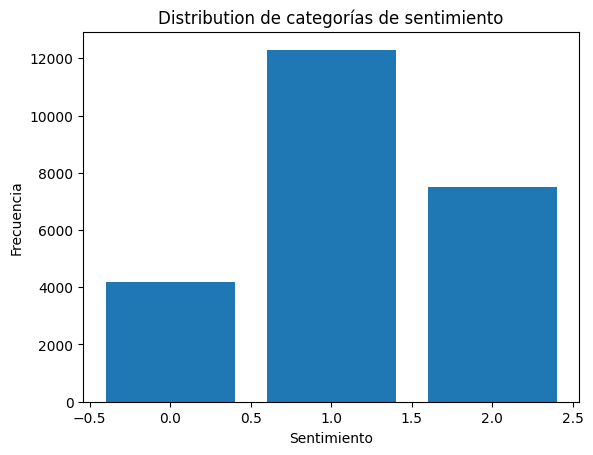

In [25]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.title('Distribution de categorías de sentimiento')
plt.show()

Vamos a pasar los datos de texto a un tensor:

In [26]:
X_train_tf = tf.convert_to_tensor(X_train)
X_val_tf = tf.convert_to_tensor(X_val)
X_test_tf = tf.convert_to_tensor(X_test)

X_train_tf

<tf.Tensor: shape=(23974,), dtype=string, numpy=
array([b'write poem #eritrea  #chatgpt\n\neritreas ancient beauty\n\neritrea land ancient beauty\nwhere red sea meets desert sand\nyour rugged mountains rise pride\nagainst sky vast grand\n\nfrom shores massawas harbor\nto highlands ...read  httpst.coz5ppp2tbaq',
       b'how #ai assist human learners medical education question dr. tiffany kung #mghanesthesia resident team researchers investigated new study specifically using #chatgpt you.s. medical licensing exam.\n\nread httpst.cook0rzhi9ju httpst.coyj1efbrevh',
       b'httpst.cojlvvbljugf make offer @sedo @undeveloped \n\n#iot #iotsolutions #iiot #industrialinternetofthings #industry #industryleaders #manufacturingindustry #automation #devices #connected #applications  #chatgpt #chatgpt4 #gpt #business #internetofthings #domains #domain httpst.codtqiarwmpi',
       ..., b'#ai #chatgpt #blockchain computerized  httpst.cozbjcby7kay',
       b'if wondering doing. made #chatgpt  chat #py

Ahora hacemos la definición de la capa Vectorize, que se utiliza para tokenización de los textos, y será el punto de entrada de nuestra red neuronal.

[***tf.keras.layers.TextVectorization***](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) es una capa de preprocesamiento que convierte características de texto en secuencias de enteros. Esta capa es útil para preparar datos de texto para su uso en modelos de aprendizaje automático.

El preprocesamiento contiene los siguientes pasos:

*   Normalizar cada ejemplo (normalmente minúsculas + eliminación de puntuación)
*   Dividir cada ejemplo en subcadenas (normalmente palabras).
*   Recombinar las subcadenas en tokens (normalmente ngramas)
*   Indexar los tokens (asociar un valor int único a cada token)
*   Transformar cada ejemplo utilizando este índice, ya sea en un vector de ints o en un vector denso de floats.

In [27]:
#Capa para tokenización
vectorize_layer = TextVectorization(
    standardize=None,
    split = "whitespace",
    max_tokens=None,
    output_mode='int',
    output_sequence_length=None)

# El método adapt permite construir el vocabulario.
vectorize_layer.adapt(X_train_tf)

A continuación un ejemplo de cómo quedan los datos después de aplicar la la tokenización

In [28]:
# Tokenizar tus datos
X_train_tk = vectorize_layer(X_train)
X_val_tk = vectorize_layer(X_val)
X_test_tk = vectorize_layer(X_test)

row_index = 2
print("Texto original en X_train:", X_train[row_index], end="\n")
print("Texto tokenizado en X_train_tk:", X_train_tk[row_index])

Texto original en X_train: alibaba invites businesses trial chatgpt rival ai chatbot report #alibaba #chatgpt 

httpst.co30yxgahhnx
Texto tokenizado en X_train_tk: tf.Tensor(
[40613    27   836  4995  5442   323 67811  3610 67970  5052 67963 19893
   572 10683 70228  3087     2    34    60   287  1368   191  1317 44340
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0], shape=(58,), dtype=int64)


Veamos como queda la representación del vocabulario del conjunto X_train

In [29]:
print("Vocabulario:", vectorize_layer.get_vocabulary())

Vocabulario: ['', '[UNK]', '#chatgpt', '#ai', 'ai', 'chatgpt', '#openai', '#artificialintelligence', '-', 'like', '&amp', 'i', 'use', '#gpt4', 'new', 'using', 'the', 'data', 'us', 'get', 'business', '#generativeai', 'could', 'via', 'help', 'one', 'technology', 'make', 'know', 'time', '#technology', 'chat', 'read', 'language', '#chatgpt4', 'asked', '@openai', 'would', 'check', 'world', 'future', '#midjourney', 'take', 'better', 'it', 'think', 'see', 'course', 'write', '#machinelearning', 'this', 'tools', 'learn', 'create', 'italy', 'people', 'gpt', 'need', 'power', 'let', '#gpt', 'generative', 'first', 'good', 'what', 'way', 'how', 'work', '.', 'content', 'used', 'intelligence', 'privacy', 'human', 'tool', 'artificial', 'even', 'want', 'google', 'tech', '...', '#google', '#chatgpt.', 'going', '#tech', 'chatbot', 'latest', 'openai', 'prompt', 'digital', 'best', 'ask', '#bard', 'a', 'prompts', 'discover', 'cannot', '|', 'news', 'next', 'we', 'today', 'article', 'code', 'free', 'also', 'li

In [30]:
print("Configuración:", vectorize_layer.get_config())

Configuración: {'name': 'text_vectorization', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'max_tokens': None, 'standardize': None, 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': None, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 72371}


Analizamos y visualizamos la longitud de las secuencias de texto en el conjunto de entrenamiento X_train

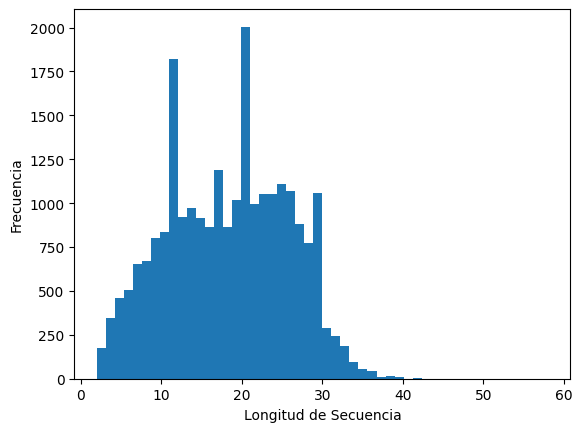

In [31]:
sequence_lengths = [len(text.split()) for text in X_train]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Longitud de Secuencia')
plt.ylabel('Frecuencia')
plt.show()

---
# 3. Modelamiento.

Definiremos la arquitectura de nuestra Red Neuronal Base. Dado que es un problema multiclase se usa ***sparse_categorical_crossentropy*** como función de pérdida y se establecen 3 neuronas en la capa de salida.

Para la entrada usaremos la capa **vectorize_layer** (definida anteriormente), seguido de una capa de **Embedding** que es una de las capas fundamentales en el procesamiento de lenguaje natural (NLP) en modelos de redes neuronales. Su función principal es convertir palabras o tokens en representaciones numéricas, lo que permite que los modelos de aprendizaje automático trabajen con texto.

La capa **LSTM** (Long Short-Term Memory) es una capa especializada en redes neuronales recurrentes (RNN) y secuencias temporales debido a su capacidad para manejar secuencias largas y capturar dependencias a largo plazo.

##3.1. Arquitectura de la red.

In [32]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    # tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
]

In [33]:
model = Sequential()

In [34]:
model.add(vectorize_layer)
model.add(Embedding(10000, 300, name="Capa_Embedding"))

In [35]:
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1024, activation='relu', name='Capa_Oculta'))
model.add(Dropout(0.8))

La capa de salida:

In [36]:
model.add(Dense(3, activation='softmax', name='Capa_Salida'))  # 3 para 3 clases

Compilamos el modelo:

In [37]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##3.2. Entrenamiento

Verificamos el estado de la GPU:

In [38]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Iniciamos el proceso de entrenamiento:

In [39]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      X_train_tf, y_train,
      validation_data = (X_val_tf, y_val),
      epochs=20,
      callbacks=my_callbacks)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.5512 - loss: 0.9734 - val_accuracy: 0.6627 - val_loss: 0.7809
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 80ms/step - accuracy: 0.7030 - loss: 0.7096 - val_accuracy: 0.7120 - val_loss: 0.6872
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 76ms/step - accuracy: 0.8078 - loss: 0.4872 - val_accuracy: 0.7171 - val_loss: 0.6794
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.8704 - loss: 0.3547 - val_accuracy: 0.7134 - val_loss: 0.8387
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.9078 - loss: 0.2585 - val_accuracy: 0.7114 - val_loss: 0.9359
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.9320 - loss: 0.1950 - val_accuracy: 0.7074 - val_loss: 1.0501
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.9496 - loss: 0.1491 - val_accuracy: 0.7020 - val_loss: 1.1712


Graficamos el comportamiento de la pérdida durante el entrenamiento:

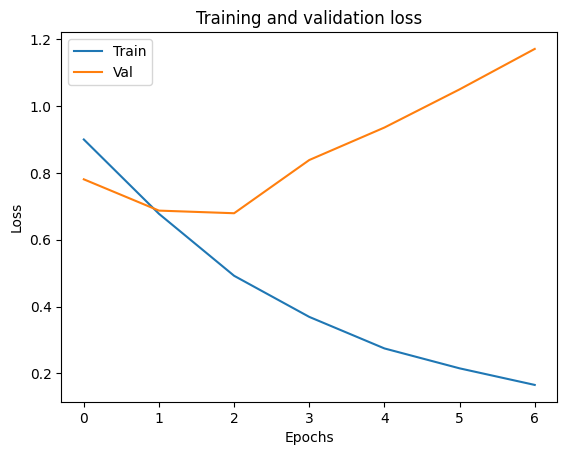

In [40]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Ahora con la métrica:

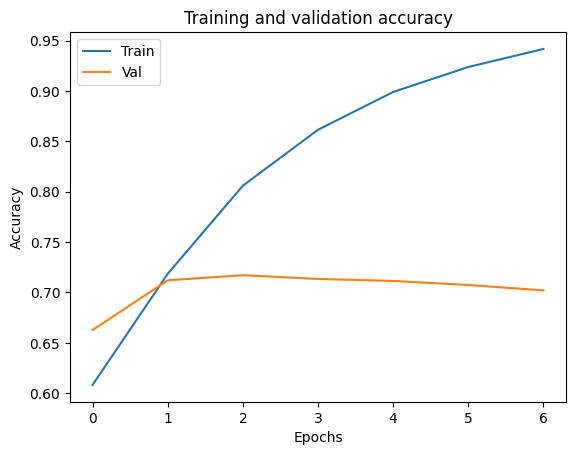

In [41]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##3.3. Evaluación

Generamos ahora predicciones del modelo base con los datos de entrenamiento:

In [42]:
y_pred = model.predict(X_train_tf)
y_pred = np.argmax(y_pred, axis=1)
y_pred

750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step


array([2, 1, 1, ..., 1, 2, 1])

Verificamos el reporte de datos:

In [43]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4184
           1       0.98      0.97      0.98     12299
           2       0.98      0.98      0.98      7491

    accuracy                           0.97     23974
   macro avg       0.97      0.97      0.97     23974
weighted avg       0.97      0.97      0.97     23974



Generamos ahora predicciones del modelo base con los datos de test:

In [44]:
y_pred_test = model.predict(X_test_tf)
y_pred_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_test))

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      1307
           1       0.75      0.75      0.75      3844
           2       0.71      0.72      0.72      2341

    accuracy                           0.71      7492
   macro avg       0.69      0.68      0.68      7492
weighted avg       0.71      0.71      0.71      7492



Este modelo básico presenta sobreajuste. Para mejorarlo, necesitamos realizar una búsqueda de hiperparámetros para lograr una mejor generalización del modelo como lo pueden ser:

Hiperparámetros de la capa LSTM
*   units
*   dropout y recurrent_dropout

Hiperparámetros de la capa de embedding
*   input_dim
*   output_dim

Hiperparámetros de capas de dropout:
*   rate

Tamaño del vocabulario y longitud de secuencia

Número de capas ocultas

Tamaño del batch y número de épocas

##3.4. Implementación de Glove

Ahora vamos a implementar una red neuronal usando un embedding pre-entrenado como lo es [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/)

Ahora cargamos los vectores de palabras pre-entrenados desde un archivo GloVe y los almacenamos en un diccionario en el que se puede buscar una palabra específica para obtener su vector correspondiente.

In [45]:
glove_embeddings = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
  for line in file:
    values = line.split()
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    glove_embeddings[word] = vector

Creamos la matriz de incrustación (embedding matrix) que contiene los vectores GloVe correspondientes a las palabras del vocabulario que se tomó del conjunto de entrenamiento X_train

In [46]:
# Número de palabras del vocabulario
num_words = vectorize_layer.vocabulary_size() + 1  # +1 para tener en cuenta la palabra OOV (Out of Vocabulary)

embedding_dim = 100  # Elige la dimensión de los vectores GloVe (por ejemplo, 100 para 'glove.6B.100d.txt')

word_index = dict(zip(vectorize_layer.get_vocabulary(), range(len(vectorize_layer.get_vocabulary()))))

# Crea la matriz de incrustación
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Las palabras en GloVe se establecen en la matriz de incrustación
        embedding_matrix[i] = embedding_vector

Determinamos la longitud máxima de secuencia dentro de tu conjunto de datos de entrenamiento. Esta longitud máxima es importante ya que establece el límite máximo de palabras en una secuencia que el modelo puede manejar.

In [47]:
max_sequence_length = max(len(seq) for seq in X_train)
max_sequence_length

612

Definimos nuestra red usando el Embedding pre-entrenado.

```
new_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
```

>  input_dim=len(word_index) + 1: El parámetro input_dim se establece en la longitud del word_index, que es el índice de palabras en tu conjunto de datos de entrenamiento. Agregamos 1 porque generalmente se suma 1 para incluir una entrada especial para palabras fuera del vocabulario (OOV - Out of Vocabulary).

>  output_dim=embedding_dim: output_dim se establece en embedding_dim, que es la dimensión de los vectores de incrustación que se utilizarán. En este caso, coincidirá con la dimensión de los vectores GloVe pre-entrenados.

>  input_length=max_sequence_length: Aquí establecemos la longitud de entrada máxima para las secuencias que se utilizarán en esta capa de incrustación. Esta longitud se definió previamente como max_sequence_length y se utiliza para asegurarse de que las secuencias se ajusten a la longitud máxima especificada.

>  weights=[embedding_matrix]: weights se establece en embedding_matrix, que es la matriz de incrustación pre-entrenada. Esta matriz contiene los vectores GloVe pre-entrenados para las palabras de tu vocabulario.

>  trainable=False: trainable se establece en False, lo que significa que los vectores de incrustación no se entrenarán o modificarán durante el entrenamiento del modelo.

In [48]:
new_model = Sequential()

new_model.add(vectorize_layer)
new_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
new_model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))
new_model.add(Dense(1024, activation='relu', name='Capa_Oculta'))
new_model.add(Dropout(0.8))
new_model.add(Dense(3, activation='softmax', name='Capa_Salida'))  # 3 para 3 clases

new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entrenamos la red neuronal:

In [49]:
with tf.device('/device:GPU:0'):
  new_model.fit(
      X_train_tf, y_train,
      validation_data = (X_val_tf, y_val),
      epochs=20,
      callbacks=my_callbacks)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 66ms/step - accuracy: 0.5577 - loss: 0.9337 - val_accuracy: 0.6597 - val_loss: 0.7825
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.6326 - loss: 0.8176 - val_accuracy: 0.6834 - val_loss: 0.7184
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 66ms/step - accuracy: 0.6604 - loss: 0.7750 - val_accuracy: 0.6975 - val_loss: 0.6953
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 71ms/step - accuracy: 0.6751 - loss: 0.7417 - val_accuracy: 0.7095 - val_loss: 0.6966


In [ ]:
y_pred = new_model.predict(X_train_tf)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred))

273/750 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step

In [ ]:
y_pred = new_model.predict(X_test_tf)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

---
# 4. Preguntas.

1.  ¿Cómo afectaría el Tamaño del Embedding en el rendimiento del Modelo?
2.  Implemente la búsqueda de hiperparámetros para mejorar el modelo base.